In [1]:
import Functions 
from PIL import Image, ImageFilter
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy import ndimage
from scipy.stats import randint, uniform, skew, kurtosis
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA
import joblib



In [ ]:
folder_path = "images"
excel_path = "data.csv"

In [ ]:
images, file_names = Functions.load_images_from_folder(folder_path)

df_excel = pd.read_csv(excel_path, usecols=["Patient", "histological_type"])
df_excel = df_excel.dropna()

print(f"{len(images)} adet resim yüklendi.")

3929 adet resim yüklendi.


In [ ]:
df_list = []

for img_bgr, file_name in zip(images, file_names):
    try:
        texture_feats = Functions.glcm(img_bgr)
        hog_hist = Functions.hog(img_bgr)
        lbp_img = Functions.lbp(img_bgr)
        lbp_hist = Functions.lbp_histogram(lbp_img)
        glcm_matrix = Functions.glcm_matr(img_bgr, distance=1, angle=0)
        glcm_feats = Functions.glcm_features(glcm_matrix)

        label = df_excel.loc[df_excel["Patient"] == str(file_name[:12]), "histological_type"].values[0]

        df = Functions.features_to_dataframe(
            histological_type=label,
            patient=file_name,
            texture_feats=texture_feats,
            hog_hist=hog_hist,
            lbp_hist=lbp_hist,
            glcm_feats=glcm_feats
        )

        df_list.append(df)
    except:
        pass

final_df = pd.concat(df_list, ignore_index=True)


In [13]:
X = final_df.iloc[:, 2:].values 
X_pca, pca_model = Functions.apply_pca(X, n_components=100)
joblib.dump(pca_model, "modeller/pca_model.pkl")


y = final_df['histological_type']
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)   

PCA sonrası boyut: (3841, 100)
Açıklanan varyans oranı toplamı: 0.9996


# Modellerin Eğitimi

## MLP - Multilayer Perceptron

Best MLP Params: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'activation': 'tanh'}

MLP Results:
  Accuracy: 0.8739
  Recall (macro): 0.8715
  F1-Score (macro): 0.8700


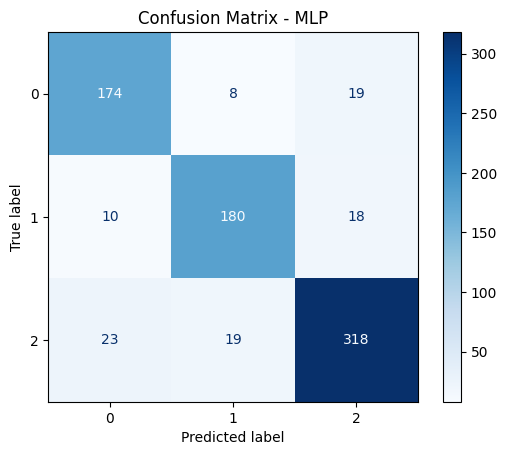

  AUC (micro-average): 0.9719


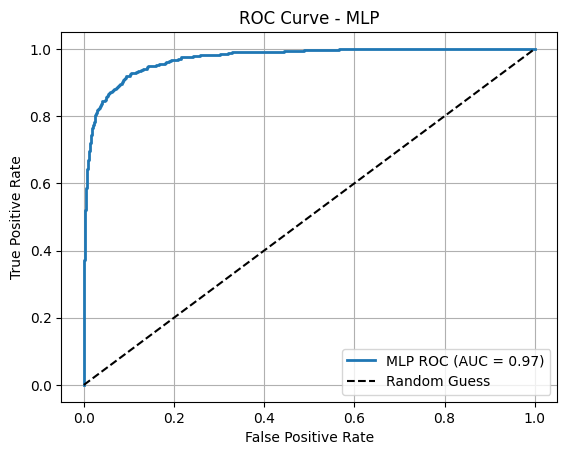

In [14]:
param_dist_mlp = {
    "hidden_layer_sizes": [(100,), (100, 50), (200,), (500,)],
    "activation": ["tanh"],
    "solver": ["adam", "sgd"],
    "learning_rate": ["constant"]
}

mlp = MLPClassifier(max_iter=300, random_state=42)
rs_mlp = RandomizedSearchCV(mlp, param_distributions=param_dist_mlp, n_iter=5, cv=3, n_jobs=-1, random_state=42)
rs_mlp.fit(X_train, y_train)
joblib.dump(rs_mlp.best_estimator_, "modeller/mlp_model.sav")
y_pred_mlp = rs_mlp.predict(X_test)
print("Best MLP Params:", rs_mlp.best_params_)
Functions.evaluate_model("MLP", rs_mlp.best_estimator_, X_test, y_test)



## SVM - Support Vector Machine

Best SVM Params: {'kernel': 'linear'}

SVM Results:
  Accuracy: 0.7100
  Recall (macro): 0.6840
  F1-Score (macro): 0.6851


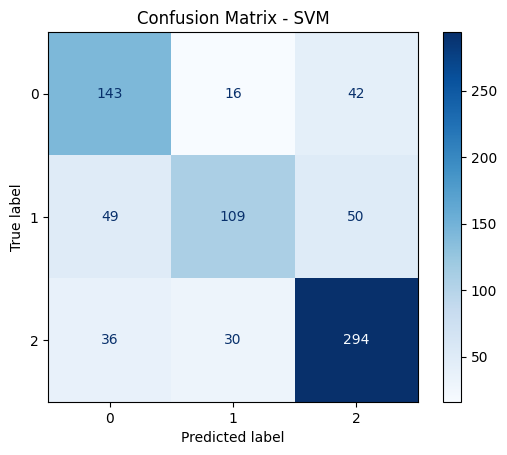

  AUC (micro-average): 0.8360


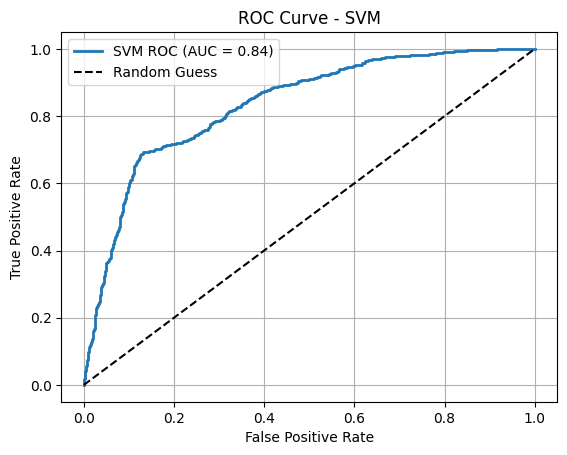

In [ ]:
param_dist_svm = {
    "kernel": ["rbf", "linear", "poly"]
}

svm = SVC(random_state=42)
rs_svm = RandomizedSearchCV(svm, param_distributions=param_dist_svm, n_iter=3, cv=3, n_jobs=-1, random_state=42)
rs_svm.fit(X_train, y_train)
joblib.dump(rs_svm.best_estimator_, "modeller/svm_model.sav")
y_pred_svm = rs_svm.predict(X_test)
print("Best SVM Params:", rs_svm.best_params_)
Functions.evaluate_model("SVM", rs_svm.best_estimator_, X_test, y_test)

## RF - Random Forest

Best RF Params: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 199}

Random Forest Results:
  Accuracy: 0.8010
  Recall (macro): 0.7531
  F1-Score (macro): 0.7859


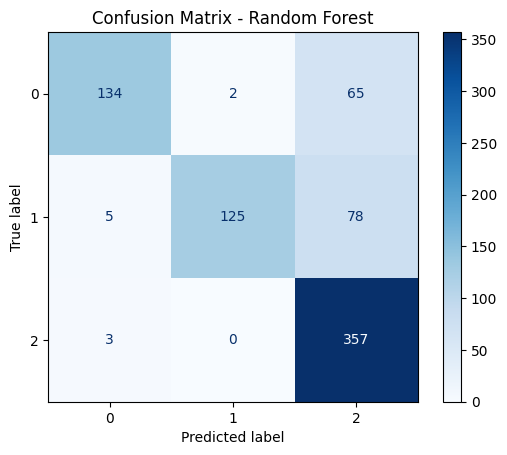

  AUC (micro-average): 0.9430


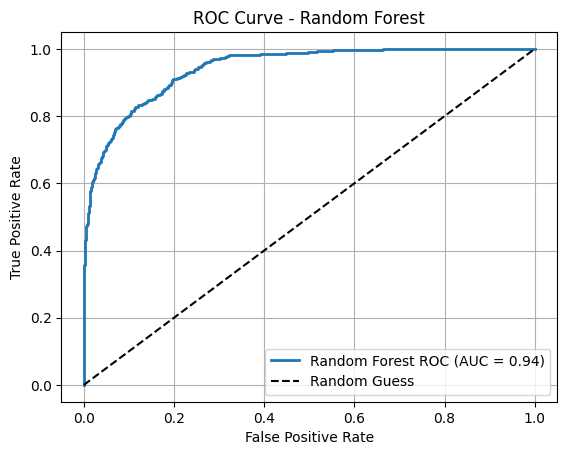

In [ ]:
param_dist_rf = {
    "n_estimators": randint(100, 300),  
    "max_depth": randint(5, 30),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5)
}

rf = RandomForestClassifier(random_state=42)
rs_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=5, cv=3, n_jobs=-1, random_state=42)
rs_rf.fit(X_train, y_train)
joblib.dump(rs_rf.best_estimator_, "modeller/rf_model.sav")
y_pred_rf = rs_rf.predict(X_test)
print("Best RF Params:", rs_rf.best_params_) 
Functions.evaluate_model("Random Forest", rs_rf.best_estimator_, X_test, y_test)

    